In [1]:
import polars as pl
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, f1_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
df = pl.read_csv("..\\data\\cleaned.csv")

In [3]:
target_col = "Credit_Score"

X = df.drop(target_col)
y = df[target_col]

In [4]:
score_map = {
    "Poor": 0,
    "Standard": 1,
    "Good": 2
}

y_encoded = y.replace(score_map).cast(pl.Int8)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=37, stratify=y_encoded
)

In [6]:
from sklearn.utils.class_weight import compute_sample_weight
sample_weights = compute_sample_weight("balanced", y_train)

# XGBoost

In [7]:
model = XGBClassifier(
    objective="multi:softprob",
    num_class=len(score_map.keys()),
    eval_metric="mlogloss",
    random_state=37,
    tree_method="hist",
    n_estimators=5000,
    learning_rate=0.04,
    early_stopping_rounds=200,
)

In [8]:
model.fit(
    X_train, y_train,
    sample_weight=sample_weights,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=200
)

[0]	validation_0-mlogloss:1.07654	validation_1-mlogloss:1.07669
[200]	validation_0-mlogloss:0.65048	validation_1-mlogloss:0.67850
[400]	validation_0-mlogloss:0.58051	validation_1-mlogloss:0.63304
[600]	validation_0-mlogloss:0.52830	validation_1-mlogloss:0.60076
[800]	validation_0-mlogloss:0.48577	validation_1-mlogloss:0.57566
[1000]	validation_0-mlogloss:0.45147	validation_1-mlogloss:0.55772
[1200]	validation_0-mlogloss:0.42123	validation_1-mlogloss:0.54347
[1400]	validation_0-mlogloss:0.39600	validation_1-mlogloss:0.53296
[1600]	validation_0-mlogloss:0.37241	validation_1-mlogloss:0.52346
[1800]	validation_0-mlogloss:0.35112	validation_1-mlogloss:0.51523
[2000]	validation_0-mlogloss:0.33221	validation_1-mlogloss:0.50851
[2200]	validation_0-mlogloss:0.31424	validation_1-mlogloss:0.50280
[2400]	validation_0-mlogloss:0.29826	validation_1-mlogloss:0.49868
[2600]	validation_0-mlogloss:0.28362	validation_1-mlogloss:0.49525
[2800]	validation_0-mlogloss:0.27021	validation_1-mlogloss:0.49276
[3

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,200
,enable_categorical,False
,eval_metric,'mlogloss'


In [9]:
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred, target_names=score_map.keys()))

              precision    recall  f1-score   support

        Poor       0.78      0.88      0.83      5799
    Standard       0.87      0.77      0.82     10635
        Good       0.73      0.85      0.79      3566

    accuracy                           0.82     20000
   macro avg       0.80      0.83      0.81     20000
weighted avg       0.82      0.82      0.82     20000



# Plots

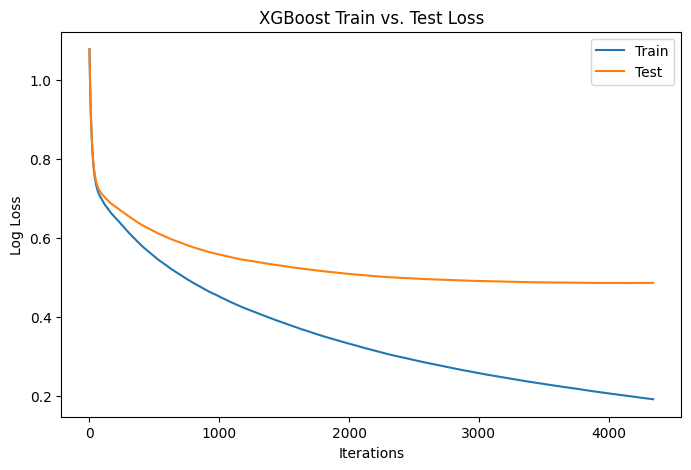

In [10]:
results = model.evals_result()

epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

plt.figure(figsize=(8, 5))
plt.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
plt.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('XGBoost Train vs. Test Loss')
plt.legend()
plt.show()

In [ ]:
reversed_score_map = {
    0: "Poor",
    1: "Standard",
    2: "Good"
}

Decode = np.vectorize(lambda x: reversed_score_map.get(x, None))

In [16]:
y_test = Decode(y_test)
y_pred = Decode(y_pred)

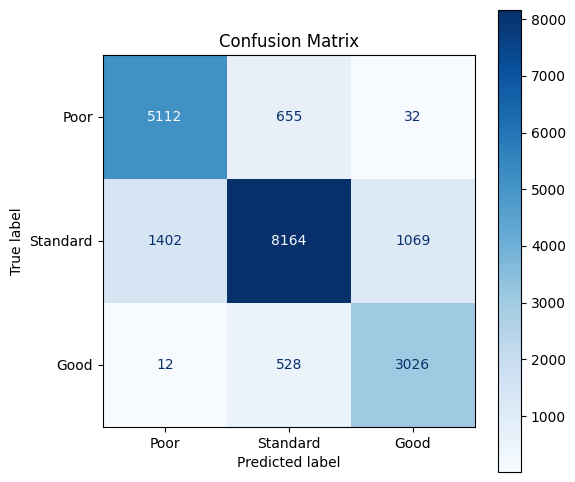

In [20]:
cm = confusion_matrix(y_test, y_pred, labels=list(reversed_score_map.values()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=reversed_score_map.values())

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap="Blues", ax=ax, values_format='d')
plt.title("Confusion Matrix")
plt.show()

# Saving

In [11]:
import joblib

# Example: XGB trained with preprocessed features
joblib.dump(model, "..\\credit_model.pkl")

['..\\credit_model.pkl']